In [31]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [32]:
# 标签名称
LABEL_NAME = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

label_dict = {}
for i, name in enumerate(LABEL_NAME):
    label_dict[name] = i

label_dict

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

## 定义数据集类并加载数据集

In [44]:
# 训练数据集增强
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((28, 28)),  # 改变大小
    transforms.RandomHorizontalFlip(),  # 水平翻转
    transforms.RandomVerticalFlip(),  # 垂直翻转
    transforms.RandomRotation(90),  # 旋转90°
    transforms.RandomGrayscale(0.1),  # 增加灰度
    transforms.ColorJitter(.3, .3, .3, .3),
    transforms.ToTensor()
])


# 定义读取数据集类
class MyDataset(Dataset):
    def __init__(self, img_list, transform=None, loader=None):
        super(MyDataset, self).__init__()

        self.transform = transform

        self.loader = loader
        if not self.loader:
            self.loader = self.image_loader

        self.img_info = []
        for path in img_list:
            img_label = path.split('\\')[-2]
            self.img_info.append((path, LABEL_NAME.index(img_label)))
            # img_info.append((path, label_dict[img_label]))

    def __getitem__(self, index):
        img_path, img_label = self.img_info[index]

        img_data = self.loader(img_path)

        # 是否进行图像增强处理
        if self.transform is not None:
            img_data = self.transform(img_data)

    def __len__(self):
        return len(self.img_info)

    @staticmethod
    def image_loader(path):
        return Image.open(path).convert('RGB')

In [45]:
import glob

# 获取全部的训练集图片路径以及测试集图片路径
img_train_list = glob.glob('../00-data/cifar-10-python/train/*/*.png')
img_test_list = glob.glob('../00-data/cifar-10-python/test/*/*.png')

In [46]:
img_train_list[0].split('\\')

['../00-data/cifar-10-python/train', 'airplane', 'aeroplane_s_000004.png']

In [52]:
train_dataset = MyDataset(img_train_list, transform=train_transform)  # 测试集图片需要进行图片增强处理
test_dataset = MyDataset(img_test_list, transform=transforms.ToTensor())  # 训练集图片不需要
len(train_dataset), len(test_dataset)

(50000, 10000)

## 加载数据集类

In [53]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=6,
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=6,
    num_workers=4
)

## 搭建VGGNet

In [ ]:
import torch


class VGGBase(torch.nn.Module):
    def __init__(self):
        super(VGGBase, self).__init__()

        # 3 * 28 * 28(crop-->32, 28)
        self.conv_00 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )

        self.max_pooling_00 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

        # 14 * 14
        self.conv_01_00 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU()
        )

        self.conv_01_01 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU()
        )

        self.max_pooling_01 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # 7 * 7
        self.conv_02_00 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU()
        )

        self.conv_02_01 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU()
        )

        self.max_pooling_02 = torch.nn.MaxPool2d(
            kernel_size=2,
            stride=2,
            padding=1
        )

        # 4 * 4
        self.conv_03_00 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU()
        )

        self.conv_03_01 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU()
        )

        self.max_pooling_03 = torch.nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )

        self.fc = torch.nn.Linear(215 * 4, 10)

    def forward(self, x):
        ...

## 小Tips

In [56]:
# 一个小例子演示super关键字的用法，以及Python中继承父类如何实现
class FooParent(object):
    def __init__(self):
        self.parent = 'I\'m the parent.'
        print('Parent')

    def bar(self, message):
        print("%s from Parent" % message)


class FooChild(FooParent):
    def __init__(self):
        # super(FooChild,self) 首先找到 FooChild 的父类（就是类 FooParent），然后把类 FooChild 的对象转换为类 FooParent 的对象
        super(FooChild, self).__init__()
        print('Child')

    def bar(self, message):
        # super(FooChild, self).bar(message)
        print('Child bar fuction')
        print(self.parent)


if __name__ == '__main__':
    fooChild = FooChild()
    fooChild.bar('HelloWorld')

Parent
Child
Child bar fuction
I'm the parent.


In [ ]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
from sympy.functions import exp

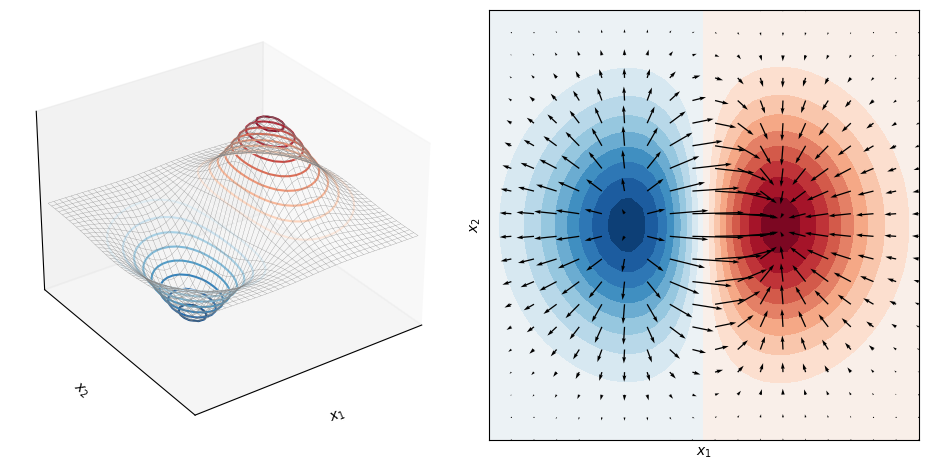

In [30]:
#define symbolic vars, function
x1, x2 = sympy.symbols('x1 x2')
f_x = x1 * exp(-(x1 ** 2 + x2 ** 2))
f_x_fcn = sympy.lambdify([x1, x2], f_x)

#take the gradient symbolically
grad_f = [sympy.diff(f_x, var) for var in (x1, x2)]
grad_fcn = sympy.lambdify([x1, x2], grad_f)

xx1, xx2 = np.meshgrid(np.linspace(-2, 2, 40), np.linspace(-2, 2, 40))

# coarse mesh
xx1_, xx2_ = np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2, 2, 20))

V = grad_fcn(xx1_, xx2_)
ff_x = f_x_fcn(xx1, xx2)

color_array = np.sqrt(V[0] ** 2 + V[1] ** 2)

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax.plot_wireframe(xx1, xx2, ff_x, rstride=1,
                  cstride=1, color=[0.5, 0.5, 0.5],
                  linewidth=0.2)
ax.contour3D(xx1, xx2, ff_x, 20, cmap='RdBu_r')

ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.zaxis.set_ticks([])
plt.xlim(-2, 2)
plt.ylim(-2, 2)
ax.view_init(30, -125)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(x_1,x_2)$')
plt.tight_layout()

#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2)

plt.contourf(xx1, xx2, ff_x, 20, cmap='RdBu_r')

plt.quiver(xx1_, xx2_, V[0], V[1],
           angles='xy', scale_units='xy',
           edgecolor='none', facecolor='k')
ax.set_aspect('equal')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.tight_layout()